## IMPORTS

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from tqdm import tqdm
from multiprocessing import Pool
from sklearn import preprocessing
from collections import defaultdict
import os
from datetime import datetime
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_ljungbox
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

from utils import *

warnings.filterwarnings("ignore")

## DATA


In [4]:

# Загрузка датасета
cbonds_df = pd.read_csv('Cbonds_funds_property_assets_2021.utf8.csv', sep=';')

# Удаление пропущенных значений и проверка наличия бесконечных значений в столбце "id"
cbonds_df = cbonds_df.dropna(subset=['id']).replace([np.inf, -np.inf], np.nan).dropna(subset=['id'])

# Преобразование типа данных столбца "id" в int
cbonds_df['id'] = cbonds_df['id'].astype(int)

# Преобразование столбца 'date' в формат даты
cbonds_df['date'] = pd.to_datetime(cbonds_df['date'])

cbonds_df_groupby_name_date = cbonds_df.groupby(['name', 'date'])

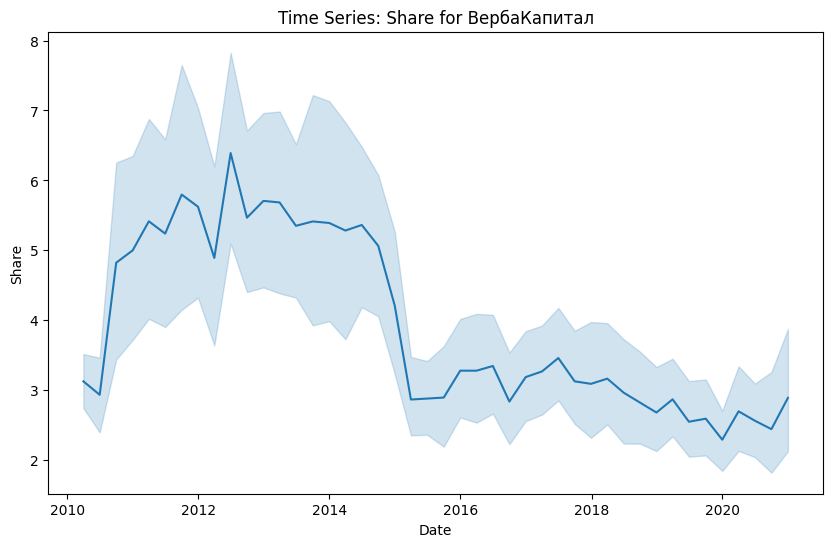

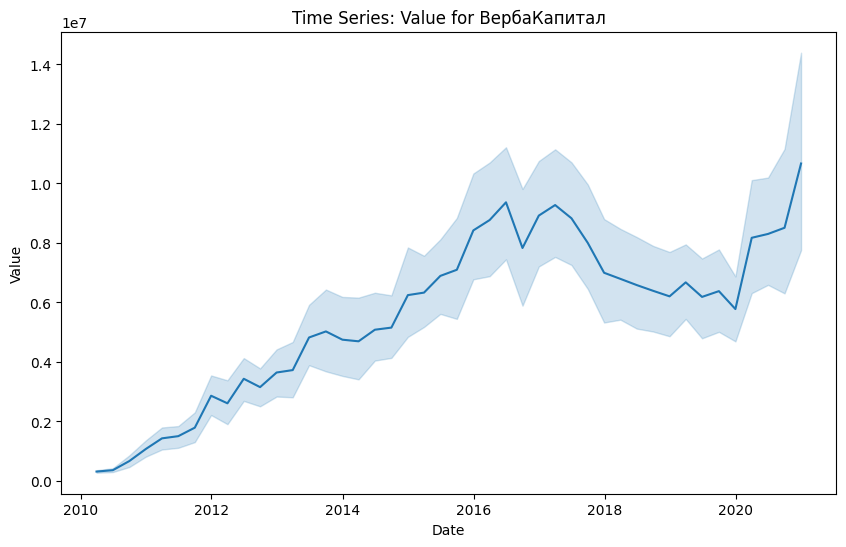

In [5]:
# График временного ряда доли 'share' для определенного фонда
selected_fund = 'ВербаКапитал'
fund_data = cbonds_df[cbonds_df['name'] == selected_fund]
plt.figure(figsize=(10, 6))
sns.lineplot(data=fund_data, x='date', y='share')
plt.title(f'Time Series: Share for {selected_fund}')
plt.xlabel('Date')
plt.ylabel('Share')
plt.show()

# График временного ряда значения 'value' для определенного фонда
plt.figure(figsize=(10, 6))
sns.lineplot(data=fund_data, x='date', y='value')
plt.title(f'Time Series: Value for {selected_fund}')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()


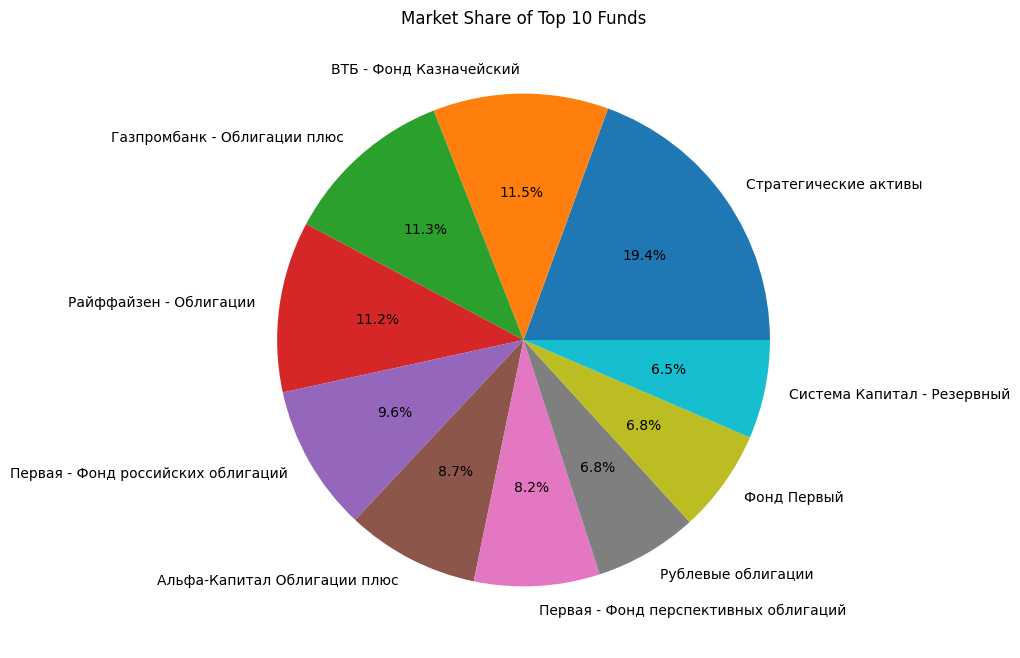

Herfindahl Index: 0.015071632352110795


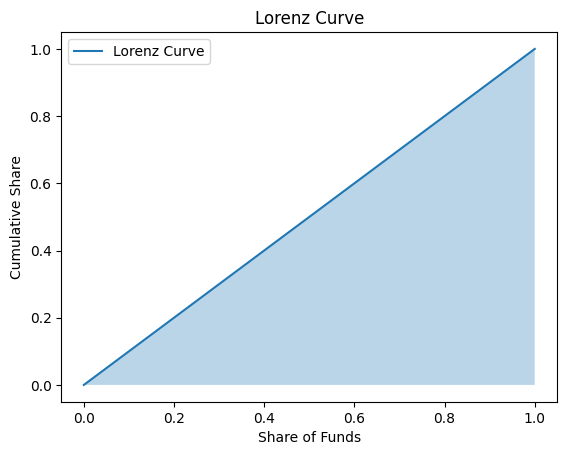

In [6]:
pai_df = pd.read_csv('funds_30062008_29012021_new (1).csv', sep=';')

# Конвертация столбца 'СЧА' в тип float
pai_df['СЧА'] = pd.to_numeric(pai_df['СЧА'], errors='coerce')

# Рассчитываем суммарную долю фонда в общем объеме для каждого фонда
fund_shares = pai_df.groupby('Фонд')['СЧА'].sum()
total_shares = fund_shares.sum()
fund_shares_percent = (fund_shares / total_shares) * 100

# Отбираем топ 10 фондов с наибольшими долями
top_funds = fund_shares_percent.nlargest(10)

# Создаем круговую диаграмму для топ 10 фондов
plt.figure(figsize=(8, 8))
plt.pie(top_funds, labels=top_funds.index, autopct='%1.1f%%')
plt.title('Market Share of Top 10 Funds')
plt.show()

# Рассчитываем индекс Херфендаля для самых больших фондов
herfindahl_index = (top_funds/100) ** 2
herfindahl_index = herfindahl_index.sum()

print(f"Herfindahl Index: {herfindahl_index}")

# Расчет доли каждого фонда в общей сумме паев
fund_shares_normalized = fund_shares / fund_shares.sum()

# Расчет кумулятивной суммы долей
cumulative_shares = fund_shares_normalized.cumsum()

# Расчет индекса Герфиндаля
gini_index = 1 - 2 * (0.5 - cumulative_shares).sum()

# Расчет доли крупнейших фондов
top_funds_share = fund_shares.nlargest(5).sum()

# Расчет доли остальных фондов
other_funds_share = fund_shares.nsmallest(len(fund_shares) - 5).sum()

# Расчет индекса Шерера
share_ratio_index = top_funds_share / other_funds_share

# Расчет кумулятивной суммы долей
cumulative_shares = fund_shares_normalized.cumsum()

# Построение графика Лоренца
plt.plot([0, 1], [0, cumulative_shares.max()], label='Lorenz Curve')
plt.fill_between([0] + cumulative_shares.tolist(), [0] + cumulative_shares.tolist(), alpha=0.3)

# Расчет площади под кривой Лоренца
area_under_curve = cumulative_shares.sum() / len(fund_shares)

# Отображение графика и площади под кривой Лоренца
plt.xlabel('Share of Funds')
plt.ylabel('Cumulative Share')
plt.title('Lorenz Curve')
plt.legend()
plt.show()

# Расчет доли крупнейших фондов
top_funds_share = fund_shares.nlargest(5).sum()

# Расчет доли всех фондов
total_share = fund_shares.sum()

# Расчет индекса Концентрации
concentration_index = top_funds_share / total_share

# Расчет индекса Херфендаля
herfindahl_index = gini_index

# Расчет индекса Джини
gini_coefficient = (herfindahl_index * 2) - 1



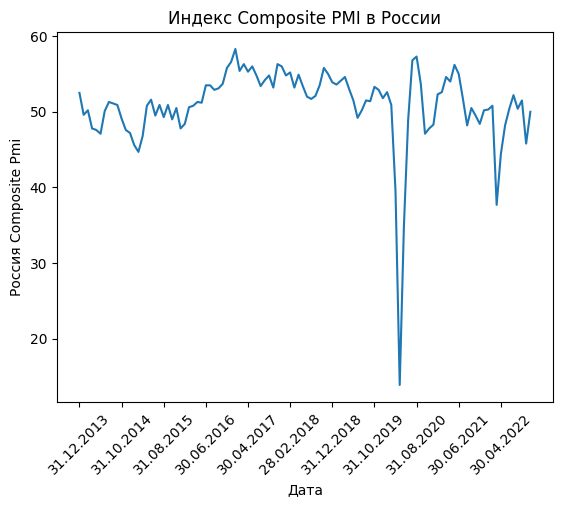

In [7]:

df_active = pd.read_csv('россия-composite-pmi.csv', sep=';')
df_active['Россия Composite Pmi'] = df_active['Россия Composite Pmi'].str.replace(',', '.').astype(float)
df_active = df_active[::-1].reset_index(drop=True)

plt.plot(df_active['Дата'], df_active['Россия Composite Pmi'])
plt.xlabel('Дата')
plt.ylabel('Россия Composite Pmi')
plt.title('Индекс Composite PMI в России')

# Настройка отображения меток оси x
plt.xticks(range(0, len(df_active['Дата']), 10), df_active['Дата'].iloc[::10], rotation=45)

plt.grid(False)  # Скрыть решетку

plt.show()

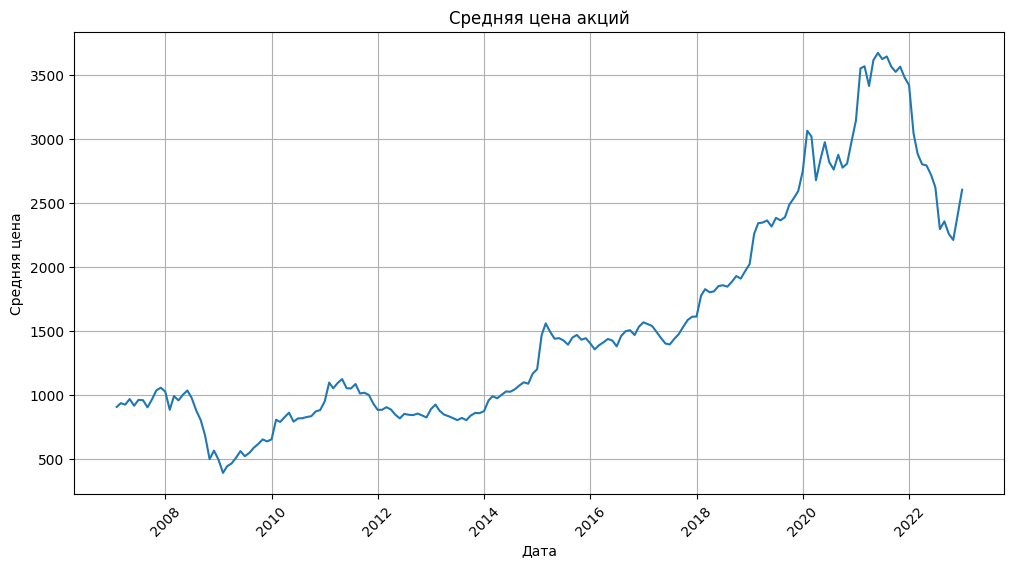

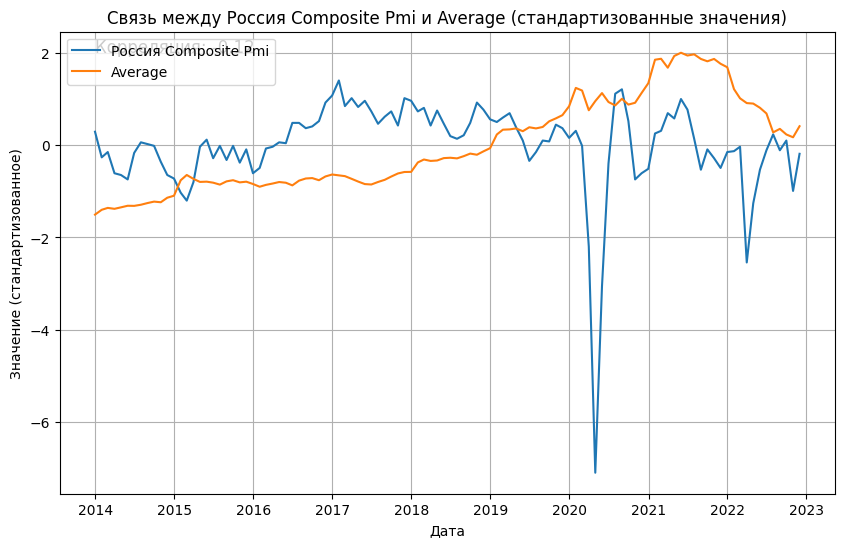

In [489]:
directory = 'data'  # Путь к директории с файлами данных
file_extension = '.xlsx'  # Расширение файлов данных

file_names = [
    os.path.splitext(file)[0]
    for file in os.listdir(directory)
    if file.endswith(file_extension)
]

stock_dict = {}
common_dates = None
for name in file_names:
    df_share = pd.read_excel(os.path.join(directory, f'{name}{file_extension}'), engine='openpyxl')
    if common_dates is None:  # Если common_dates не инициализировано
        common_dates = set(df_share['Дата'])  # Присваиваем common_dates значения первого датасета
    else:
        common_dates = common_dates.intersection(set(df_share['Дата']))

    stock_dict[name] = df_share


# Создание пустого датафрейма для объединения цен
combined_prices = pd.DataFrame()

# Объединение цен Цена avg из всех датафреймов в словаре stock_dict
for key, df in stock_dict.items():
    avg_price = pd.to_numeric(df['Цена avg'], errors='coerce')
    avg_price = avg_price.dropna()
    combined_prices[key] = avg_price

# Рассчитываем средний показатель цены по всем акциям, игнорируя строки и NaN
combined_prices['Average'] = combined_prices.apply(lambda row: np.mean(row.dropna()), axis=1)

# Создание датафрейма с колонкой 'Дата' из первого датафрейма в словаре
dates_df = stock_dict[list(stock_dict.keys())[0]][['Дата']]
dates_df['Дата'] = pd.to_datetime(dates_df['Дата'])

# Установка колонки 'Дата' в объединенном датафрейме
combined_prices['Дата'] = dates_df['Дата']

# Сэмплирование дат в определенном временном интервале (например, каждый месяц)
combined_prices = combined_prices.resample('M', on='Дата').mean().reset_index()

# Построение временного ряда среднего показателя цены
plt.figure(figsize=(12, 6))
plt.plot(combined_prices['Дата'], combined_prices['Average'])
plt.xlabel('Дата')
plt.ylabel('Средняя цена')
plt.title('Средняя цена акций')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


# Преобразование дат в формат datetime
df_active['Дата'] = pd.to_datetime(df_active['Дата'])
combined_prices['Дата'] = pd.to_datetime(combined_prices['Дата'])

# Выравнивание временных рядов по общему периоду
merged_data = pd.merge(df_active, combined_prices, on='Дата', how='inner')

# Стандартизация данных
merged_data['Россия Composite Pmi'] = (merged_data['Россия Composite Pmi'] - merged_data['Россия Composite Pmi'].mean()) / merged_data['Россия Composite Pmi'].std()
merged_data['Average'] = (merged_data['Average'] - merged_data['Average'].mean()) / merged_data['Average'].std()

# Рассчет корреляции между стандартизированными временными рядами
correlation = merged_data['Россия Composite Pmi'].corr(merged_data['Average'])

# Визуализация стандартизированных временных рядов и корреляции
plt.figure(figsize=(10, 6))
plt.plot(merged_data['Дата'], merged_data['Россия Composite Pmi'], label='Россия Composite Pmi')
plt.plot(merged_data['Дата'], merged_data['Average'], label='Average')
plt.xlabel('Дата')
plt.ylabel('Значение (стандартизованное)')
plt.title('Связь между Россия Composite Pmi и Average (стандартизованные значения)')
plt.legend()

# Вывод корреляции
plt.text(merged_data['Дата'].iloc[0], merged_data['Average'].max(), f"Корреляция: {correlation:.2f}", fontsize=12)

plt.grid(True)
plt.show()

Среднее значение:  50.964814814814815
Медиана:  51.5
Стандартное отклонение:  5.213736615719692
Минимальное значение:  13.9
Максимальное значение:  58.3


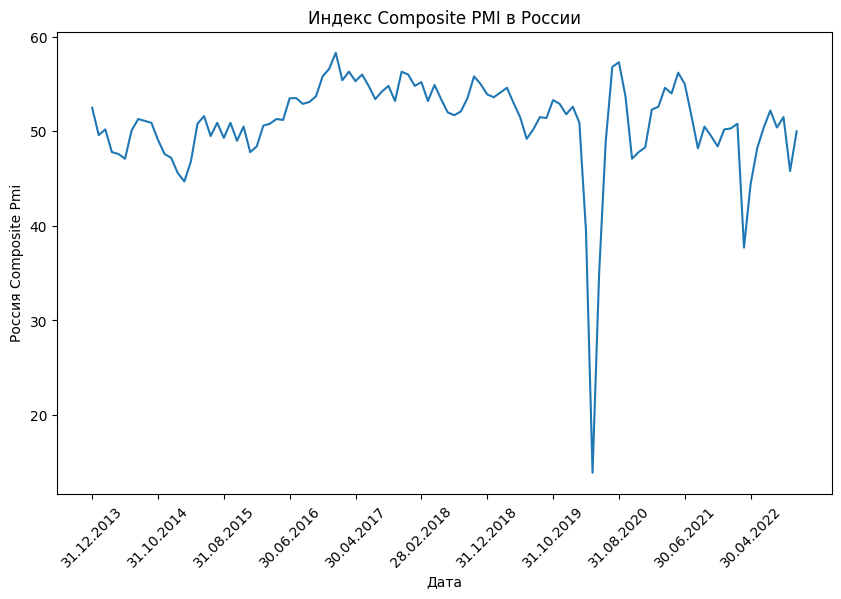

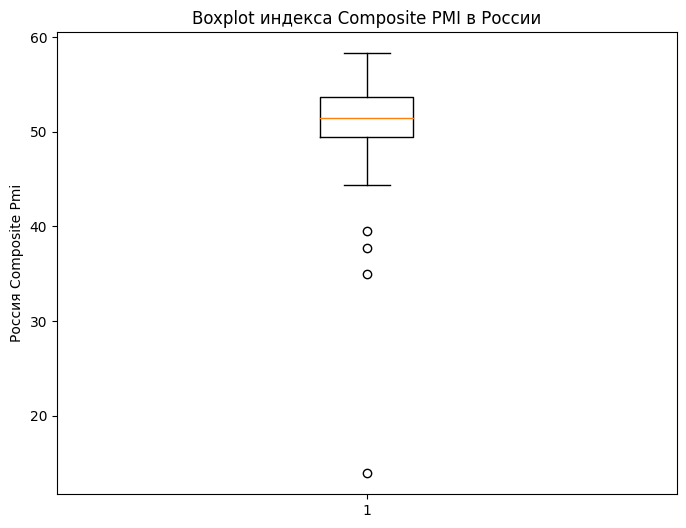

In [8]:
# Рассчитываем статистики
mean_value = df_active['Россия Composite Pmi'].mean()
median_value = df_active['Россия Composite Pmi'].median()
std_value = df_active['Россия Composite Pmi'].std()
min_value = df_active['Россия Composite Pmi'].min()
max_value = df_active['Россия Composite Pmi'].max()

# Выводим статистические показатели
print("Среднее значение: ", mean_value)
print("Медиана: ", median_value)
print("Стандартное отклонение: ", std_value)
print("Минимальное значение: ", min_value)
print("Максимальное значение: ", max_value)

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(df_active['Дата'], df_active['Россия Composite Pmi'])
plt.xlabel('Дата')
plt.ylabel('Россия Composite Pmi')
plt.title('Индекс Composite PMI в России')

# Настройка отображения меток оси x
plt.xticks(range(0, len(df_active['Дата']), 10), df_active['Дата'].iloc[::10], rotation=45)

plt.grid(False)  # Скрыть решетку

plt.show()

plt.figure(figsize=(8, 6))
plt.boxplot(df_active['Россия Composite Pmi'])
plt.ylabel('Россия Composite Pmi')
plt.title('Boxplot индекса Composite PMI в России')

plt.show()

# cbonds_group

In [9]:

# Загрузка датасета
cbonds_df = pd.read_csv('Cbonds_funds_property_assets_2021.utf8.csv', sep=';')

# Удаление пропущенных значений и проверка наличия бесконечных значений в столбце "id"
cbonds_df = cbonds_df.dropna(subset=['id']).replace([np.inf, -np.inf], np.nan).dropna(subset=['id'])

# Преобразование типа данных столбца "id" в int
cbonds_df['id'] = cbonds_df['id'].astype(int)

# Группировка и фильтрация по типу "stock" и значению "share" >= 70
cbonds_group = cbonds_df.groupby(by=["date", "id", "sec_type"]).sum(numeric_only=True)
cbonds_group = cbonds_group.loc[(slice(None), slice(None), 'stock'), :]
cbonds_group = cbonds_group[cbonds_group['share'] >= 70]

# Фильтрация по количеству данных и обновление списков
index_td_list = [i for i in cbonds_group.groupby(level=1).size().index if cbonds_group.groupby(level=1).size()[i] >= 15]
true_id = cbonds_group.index.get_level_values('id').unique().tolist()
true_date = cbonds_group.index.get_level_values('date').unique().tolist()

In [10]:
pai_df = pd.read_csv('funds_30062008_29012021_new (1).csv', sep=';')
# Ограничение датафрейма pai_df
pai_df = pai_df.loc[:1220603]
#
# Преобразование формата даты
pai_df['Дата'] = ['-'.join(i.split('.')[::-1]) for i in pai_df['Дата']]
#
# Фильтрация pai_df
cros_set = set(pai_df.Фонд).intersection(cbonds_df.name)
#
pai_df = pai_df[pai_df['Дата'].isin(true_date) & pai_df['Фонд'].isin(cros_set)]
pai_df = pai_df.iloc[:, ::-1].reset_index(drop=True)  # Инвертирование значений и сброс индексов


# Фильтрация cbonds_df
cbonds_df = cbonds_df[cbonds_df['name'].isin(cros_set) & cbonds_df['date'].isin(true_date) & cbonds_df['id'].isin(true_id)]


In [11]:
pai_df['Дата'] = pd.to_datetime(pai_df['Дата'], dayfirst=True)

df_rate = pd.read_csv('data.csv', sep = ';', names = ['data','rate'])
df_rate['data'] = np.array([np.datetime64('-'.join(i.split('.')[::-1])) for i in df_rate['data']])
pai_df['rate'] = np.nan

for i in df_rate['data']:
    pai_df.loc[pai_df['Дата'] <= i, 'rate'] = df_rate.loc[df_rate['data'] == i, 'rate'].values[0]

## Топ-n фонды

In [12]:
sum_data = cbonds_df[cbonds_df['sec_type'] == 'stock'].groupby(by=["sec_name"]).sum()
sum_data['dolia'] = sum_data['scha'].div(sum_data['scha'].sum())

sorted_data = sum_data.sort_values(by='scha', ascending=False)
share_index_big1 = sorted_data.index[:1].tolist()
share_index_big3 = sorted_data.index[:3].tolist()
share_index_big5 = sorted_data.index[:5].tolist()
share_index_big10 = sorted_data.index[:10].tolist()
share_index_big30 = sorted_data.index[:30].tolist()
share_index_big50 = sorted_data.index[:50].tolist()

## Индекс фондов

In [13]:
data_dict = defaultdict(float)
data_list = sorted(set(cbonds_df[cbonds_df.id == id].date))

In [505]:
id_ex = list(set(cbonds_df.id))
id_ex.sort()
result = foo(id_ex)

  0%|          | 0/398 [00:00<?, ?it/s]

 35%|███▌      | 140/398 [07:36<13:52,  3.22s/it]

463


 58%|█████▊    | 231/398 [12:35<05:06,  1.83s/it]

863


100%|██████████| 398/398 [20:21<00:00,  3.07s/it]


In [569]:
result_list_sharp = []
result_list_prof = []
problem_id = []
nonproblem_id = []

for i in tqdm(result.keys()):
    if len(result[i]) >= 5:
        result_corr_sharp_diff = get_corr_all_sharp(i, plot=False, use_rate=True)
        result_corr_prof_diff = get_corr_all_sharp(i, plot=False, use_rate=False)
        
        if type(result_corr_sharp_diff) == list:
            result_list_sharp.append(result_corr_sharp_diff)
            result_list_prof.append(result_corr_prof_diff)
            nonproblem_id.append(i)
        else:
            problem_id.append(i)
    else:
        print(f'мало значений: {i}')
        problem_id.append(i)

 12%|█▏        | 46/396 [00:12<00:58,  5.97it/s]

мало значений: 134


 31%|███       | 123/396 [00:31<00:40,  6.71it/s]

мало значений: 368


 43%|████▎     | 169/396 [00:47<01:27,  2.58it/s]

мало значений: 620


 46%|████▋     | 184/396 [00:52<01:24,  2.51it/s]

мало значений: 672


 48%|████▊     | 191/396 [00:53<00:37,  5.45it/s]

мало значений: 681


 56%|█████▌    | 222/396 [01:02<00:42,  4.05it/s]

мало значений: 789


 58%|█████▊    | 230/396 [01:03<00:24,  6.81it/s]

мало значений: 862


 63%|██████▎   | 251/396 [01:08<00:24,  5.89it/s]

мало значений: 946


 64%|██████▍   | 254/396 [01:09<00:20,  7.00it/s]

мало значений: 950


 66%|██████▌   | 262/396 [01:11<00:44,  3.03it/s]

мало значений: 964


 84%|████████▍ | 334/396 [01:29<00:11,  5.34it/s]

мало значений: 1470


 86%|████████▌ | 340/396 [01:31<00:10,  5.22it/s]

мало значений: 1914


 87%|████████▋ | 346/396 [01:31<00:05,  9.44it/s]

мало значений: 1997
мало значений: 1998
мало значений: 1999


 90%|████████▉ | 356/396 [01:34<00:08,  4.76it/s]

мало значений: 2080


 96%|█████████▌| 379/396 [01:40<00:05,  3.29it/s]

мало значений: 2609


 96%|█████████▋| 382/396 [01:40<00:02,  4.95it/s]

мало значений: 3133


100%|██████████| 396/396 [01:42<00:00,  3.85it/s]

мало значений: 6073
мало значений: 6197
мало значений: 6333
мало значений: 6443
мало значений: 6575


In [571]:
get_corr_all_sharp_res = [np.array([i[j] for i in result_list_sharp]) for j in range(3)]
get_corr_all_prof_res = [np.array([i[j] for i in result_list_prof]) for j in range(3)]

Correlation (Data1): 0.0936541586058874
Correlation (Data2): -0.047517746360741096
Linear Regression (Data1)
t-статистика: 1.113022917727209
p-значение: 0.26760600477627017
Коэффициент детерминации (R-squared): 0.008771101424176697
Стандартная ошибка регрессии: 0.4006145435951871
F-статистика: 1.2388200153859938
p-значение (F-статистика): 0.2676060047762741
AIC: 145.1737485278486
BIC: 151.0854026430511
Тест на гетероскедастичность: (0.2815284601503556, 0.5957011554606089, 0.27811465924516204, 0.5987743380199859)
Тест на автокорреляцию:       lb_stat  lb_pvalue
1    5.453402   0.019530
2   13.229966   0.001340
3   16.637668   0.000839
4   24.475033   0.000064
5   27.979519   0.000037
6   30.378449   0.000033
7   31.683117   0.000046
8   32.049098   0.000091
9   32.390495   0.000170
10  32.413897   0.000342



Linear Regression (Data2)
t-статистика: -0.7135722509890347
p-значение: 0.47623122071776613
Коэффициент детерминации (R-squared): 0.002257936219203671
Стандартная ошибка регрессии:

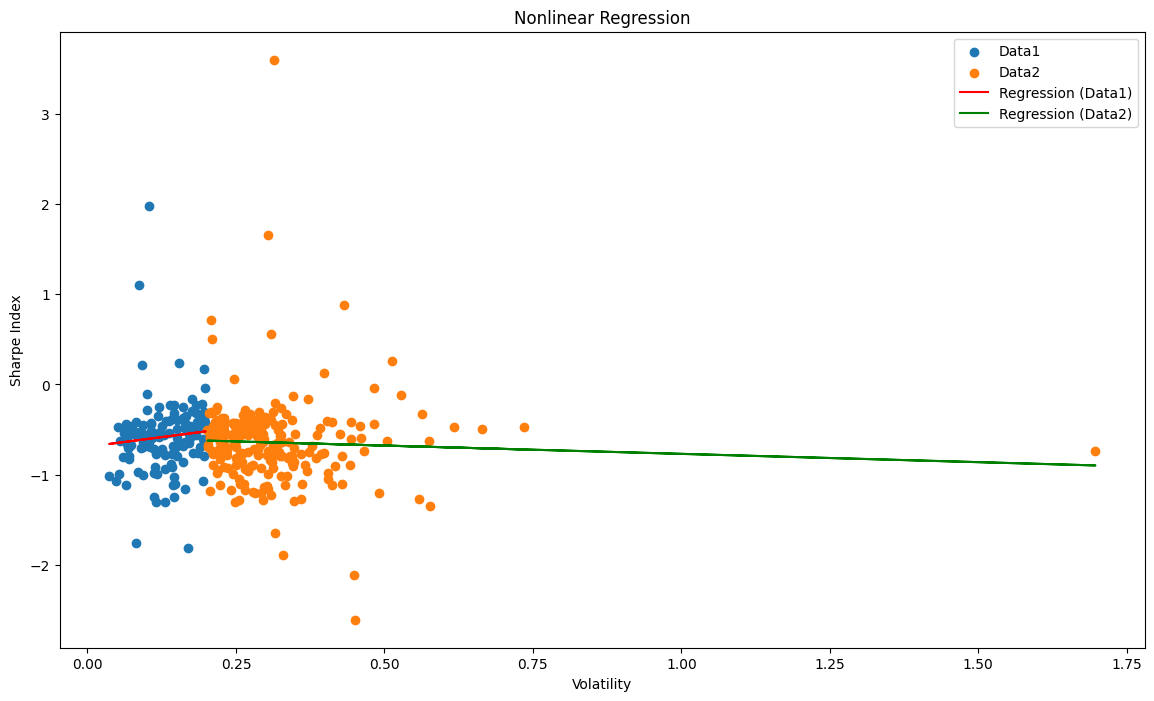

In [586]:
poly_liner_reg(get_corr_all_sharp_res[1], get_corr_all_sharp_res[2], plot=True)

Correlation (Data1): -0.04584173030912776
Correlation (Data2): 0.02780526788437963
Linear Regression (Data1)
t-статистика: -0.5429774917479152
p-значение: 0.5880087192060748
Коэффициент детерминации (R-squared): 0.002101464237734829
Стандартная ошибка регрессии: 0.44805592722334764
F-статистика: 0.29482455654486506
p-значение (F-статистика): 0.5880087192060834
AIC: 176.95855568819616
BIC: 182.87020980339867
Тест на гетероскедастичность: (0.35472066871670416, 0.551452961746333, 0.3506004143222509, 0.5547284954307928)
Тест на автокорреляцию:       lb_stat  lb_pvalue
1    0.485074   0.486133
2   20.531896   0.000035
3   20.531915   0.000132
4   21.507237   0.000251
5   22.009469   0.000521
6   22.060461   0.001181
7   22.092683   0.002449
8   22.353203   0.004302
9   22.485632   0.007461
10  22.568726   0.012455



Linear Regression (Data2)
t-статистика: 0.4163121072988297
p-значение: 0.6775802459464476
Коэффициент детерминации (R-squared): 0.0007731329221218886
Стандартная ошибка регресс

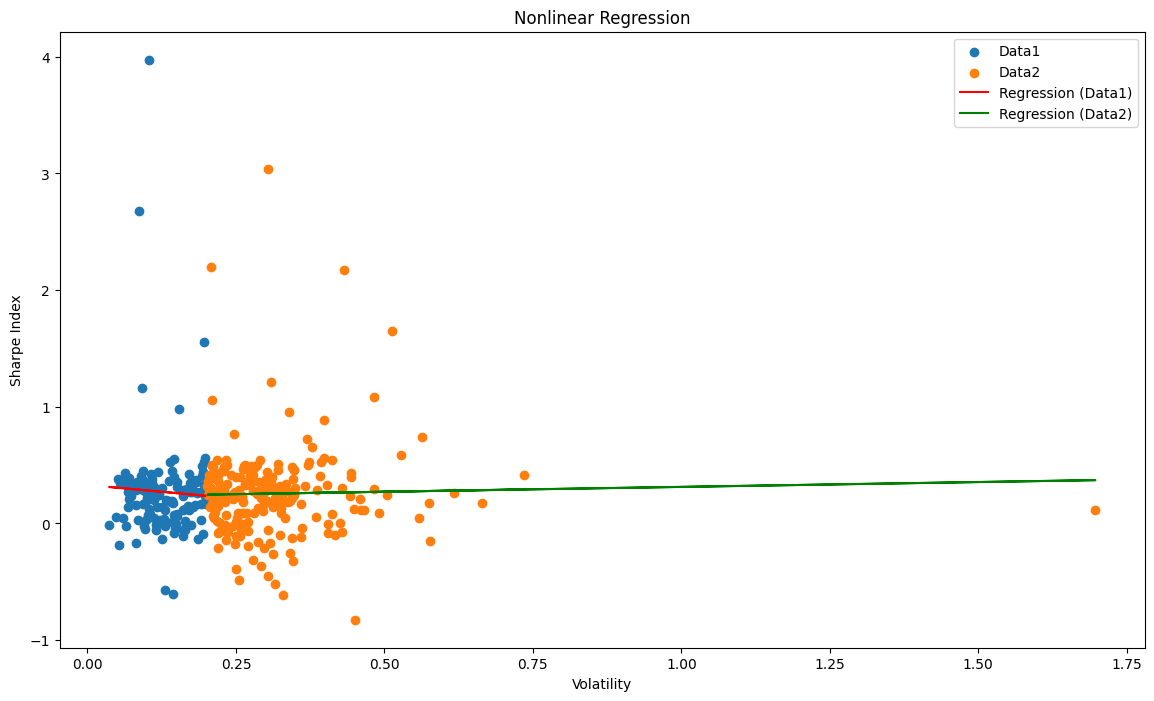

In [585]:
poly_liner_reg(get_corr_all_prof_res[1], get_corr_all_prof_res[2], plot=True)

       Volatility  Sharpe Index
count  369.000000    369.000000
mean     0.239740     -0.619209
std      0.138670      0.466350
min      0.036413     -2.607170
25%      0.146879     -0.808394
50%      0.227997     -0.596585
75%      0.304285     -0.451434
max      1.697308      3.599566
              Volatility  Sharpe Index
Volatility      1.000000     -0.060201
Sharpe Index   -0.060201      1.000000
Linear Regression (Volatility vs Sharpe Index)
t-value: -1.1553849202886077
p-value: 0.24868449442199642
R-squared: 0.0036241862016160864
Standard Error of Regression: 0.4661378373343208
F-value: 1.3349143140303716
p-value (F-value): 0.24868449442198537
AIC: 485.875059348489
BIC: 493.69665263657004
Heteroscedasticity Test: (0.8331017694748848, 0.36137715078613375, 0.8304612686984124, 0.36273735302120824)
Autocorrelation Test:        lb_stat     lb_pvalue
1    40.399279  2.070175e-10
2    77.144717  1.771077e-17
3    87.173869  8.860681e-19
4    99.953511  1.006336e-20
5   105.196987  4.23

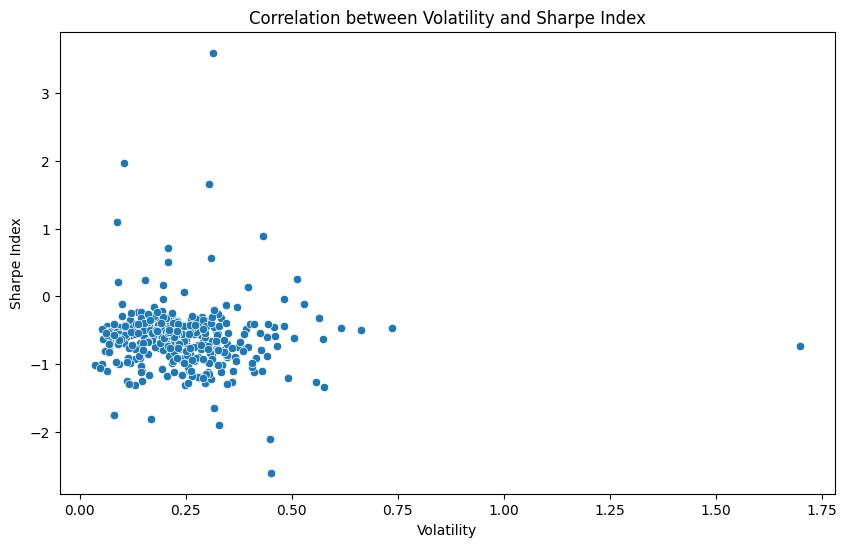

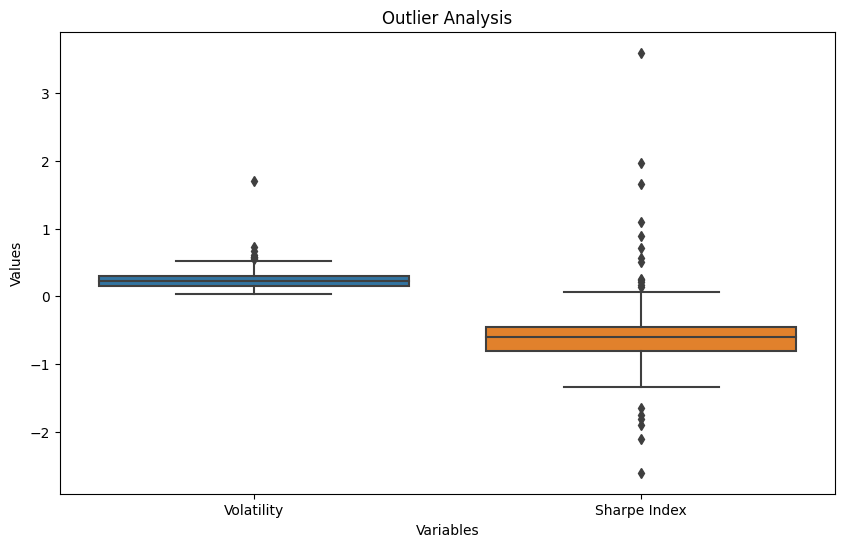

In [587]:
liner_reg(get_corr_all_sharp_res[1], get_corr_all_sharp_res[2], plot=True)

       Volatility  Sharpe Index
count  368.000000    368.000000
mean     0.239539      0.261786
std      0.138805      0.411550
min      0.036413     -0.825298
25%      0.146783      0.085790
50%      0.227321      0.248600
75%      0.303823      0.367081
max      1.697308      3.974510
              Volatility  Sharpe Index
Volatility      1.000000     -0.002543
Sharpe Index   -0.002543      1.000000
Linear Regression (Volatility vs Sharpe Index)
t-value: -0.04864557210736634
p-value: 0.9612282858336132
R-squared: 6.465509250541679e-06
Standard Error of Regression: 0.412110719600276
F-value: 0.0023663916856313362
p-value (F-value): 0.9612282858335033
AIC: 393.8963694564427
BIC: 401.7125353327806
Heteroscedasticity Test: (0.042507049021958565, 0.8366562642966018, 0.042280916247312235, 0.8371995434087824)
Autocorrelation Test:       lb_stat     lb_pvalue
1   27.558222  1.524360e-07
2   46.059648  9.960350e-11
3   72.150947  1.477682e-15
4   74.879636  2.112881e-15
5   85.192422  6.85997

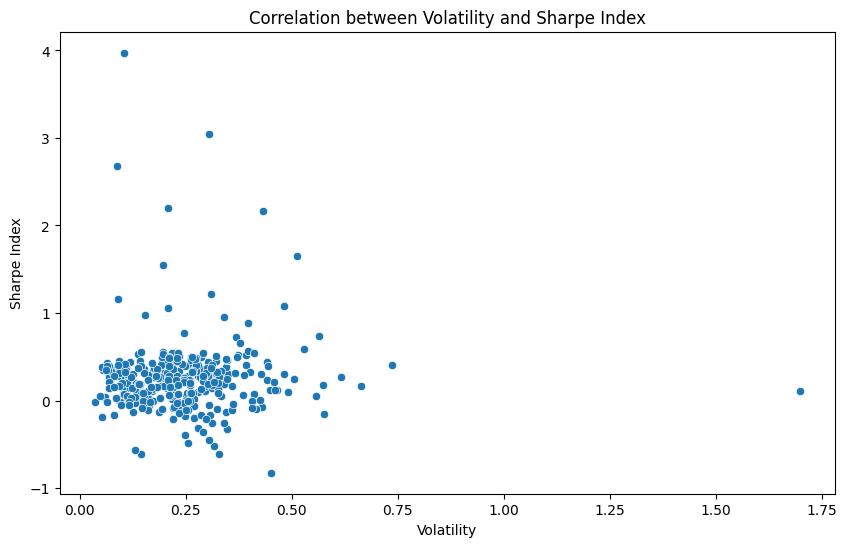

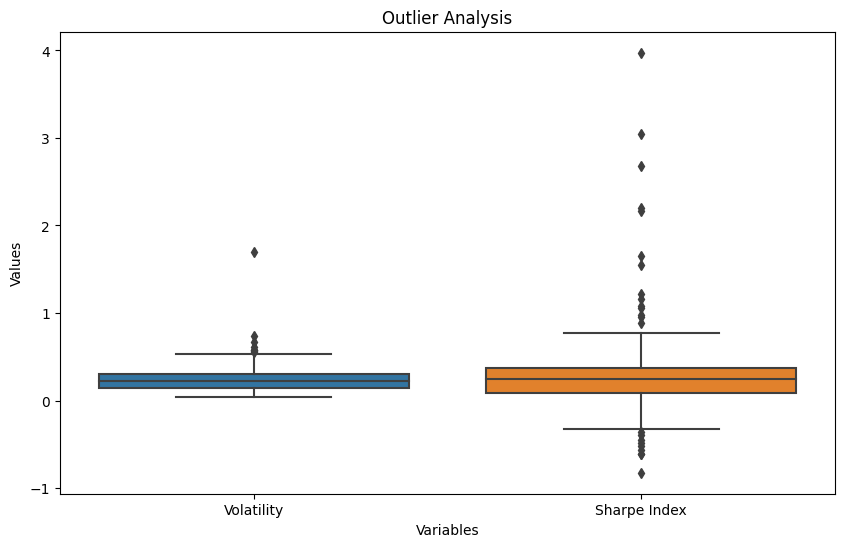

In [588]:
liner_reg(get_corr_all_prof_res[1], get_corr_all_prof_res[2], plot=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


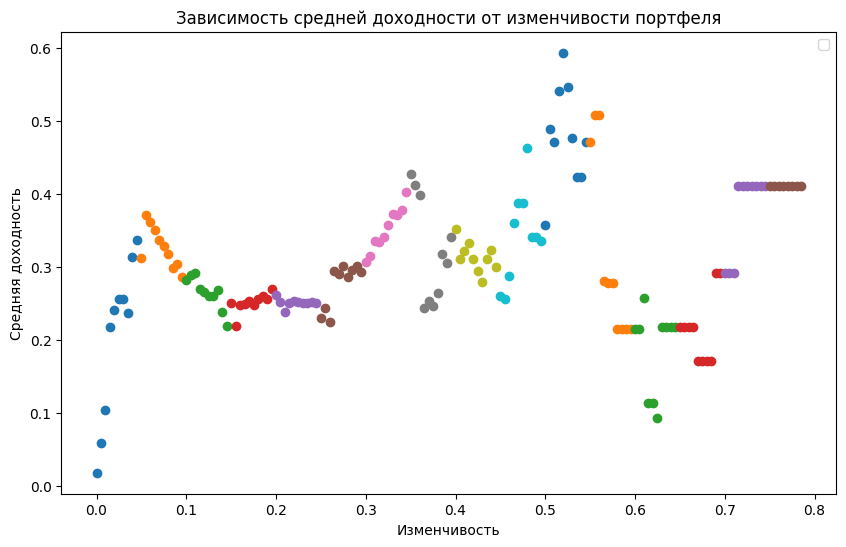

In [590]:
t = []
par = 0.05
for i in range(200):
    mask_profit = (data_prof['Volatility']<=(i/200+par)) & (data_prof['Volatility']>=(i/200-par))
    mean_profit = data_prof['Profit Index'][mask_profit].mean()
    t.append(mean_profit)
t = np.array(t)

plt.figure(figsize=(10, 6))
for k in range(1, 20):
    plt.scatter(np.array([i/200 for i in range(200)])[10*(k-1):10*k], t[10*(k-1):10*k])
    
plt.title('Зависимость средней доходности от изменчивости портфеля')
plt.xlabel('Изменчивость')
plt.ylabel('Средняя доходность')
plt.legend()
plt.show()


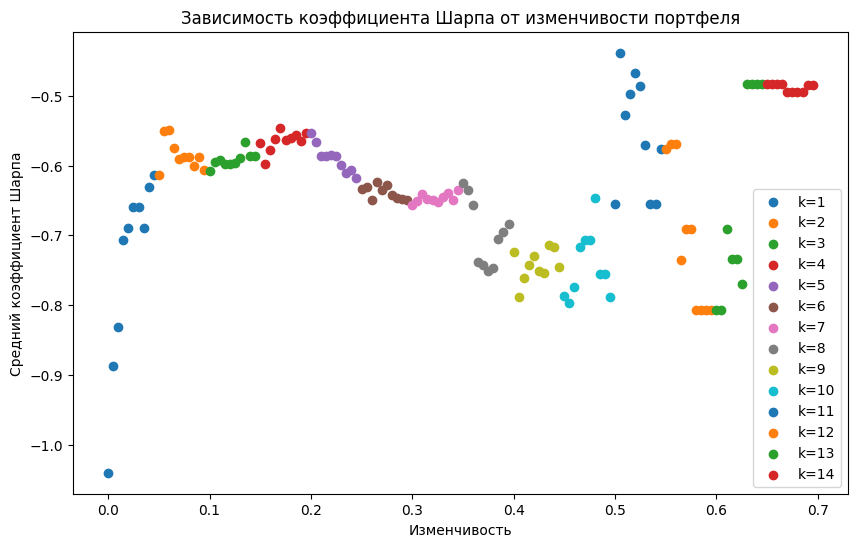

In [592]:
t_sharpe = []
par = 0.05
for i in range(200):
    mask_sharpe = (data_sharpe['Volatility']<=(i/200+par)) & (data_sharpe['Volatility']>=(i/200-par))
    mean_sharpe = data_sharpe['Sharpe Index'][mask_sharpe].mean()
    t_sharpe.append(mean_sharpe)
t_sharpe = np.array(t_sharpe)

plt.figure(figsize=(10, 6))
for k in range(1, 15):
    plt.scatter(np.array([i/200 for i in range(200)])[10*(k-1):10*k], t_sharpe[10*(k-1):10*k], label=f'k={k}')
    

plt.title('Зависимость коэффициента Шарпа от изменчивости портфеля')
plt.xlabel('Изменчивость')
plt.ylabel('Средний коэффициент Шарпа')
plt.legend()
plt.show()